In [118]:
# ------------------------- IMPORTACIONES -------------------------
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
    

In [120]:
df = pd.read_csv('HDHI Admission data.csv', sep=',')

In [122]:
# Fechas convertidas a datetime
df['D.O.A_manual'] = df['D.O.A'].apply(lambda x: pd.to_datetime(x, errors='coerce', dayfirst=False))
df['D.O.A'] = df['D.O.A_manual']
df.drop(columns='D.O.A_manual', inplace=True)

# Verificar cuántas fechas nulas hay en cada una
nulos_doa = df['D.O.A'].isna().sum()

# Rango de fechas disponibles
min_doa = df['D.O.A'].min()
max_doa = df['D.O.A'].max()

duration_col = 'DURATION OF STAY'

# Ver estadísticas generales
duration_stats = df[duration_col].describe()

# Verificar valores negativos o inconsistentes
invalid_duration = df[df[duration_col] < 0]

duration_stats, invalid_duration.shape[0]


/var/folders/tm/_mcsvvpd5ml8xhw8l_7314j80000gn/T/ipykernel_50506/1322510359.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['D.O.A_manual'] = df['D.O.A'].apply(lambda x: pd.to_datetime(x, errors='coerce', dayfirst=False))


(count    15757.000000
 mean         6.415054
 std          5.011421
 min          1.000000
 25%          3.000000
 50%          5.000000
 75%          8.000000
 max         98.000000
 Name: DURATION OF STAY, dtype: float64,
 0)

In [123]:
df = df.sort_values(by='D.O.A')

In [126]:
df['HB'] = pd.to_numeric(df['HB'], errors='coerce')
conteo = (df['HB'] < 9).sum()

print(f"Número de registros con HB < 9: {conteo}")

Número de registros con HB < 9: 1339


In [128]:
# Convertir columnas relevantes a numérico, manejando valores no numéricos
numeric_cols = ['HB', 'DURATION OF STAY', 'duration of intensive unit stay', 'CREATININE', 'UREA', 'PLATELETS', 'BNP', 'EF']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Crear la variable proxy para transfusión
def create_transfusion_proxy(row):
    # Criterio principal: Hemoglobina baja (<8 g/dL) o anemia severa
    hb_condition = row['HB'] < 8 if pd.notna(row['HB']) else False
    severe_anemia_condition = row['SEVERE ANAEMIA'] == 1 if 'SEVERE ANAEMIA' in row else False
    
    # condiciones de gravedad que podrían requerir transfusión
    cva_bleed = row['CVA BLEED'] == 1 if 'CVA BLEED' in row else False
    stemi = row['STEMI'] == 1 if 'STEMI' in row else False
    cardiogenic_shock = row['CARDIOGENIC SHOCK'] == 1 if 'CARDIOGENIC SHOCK' in row else False
    shock = row['SHOCK'] == 1 if 'SHOCK' in row else False
    pulmonary_embolism = row['PULMONARY EMBOLISM'] == 1 if 'PULMONARY EMBOLISM' in row else False
    ckd = row['CKD'] == 1 if 'CKD' in row else False
    emergencia = row['TYPE OF ADMISSION-EMERGENCY/OPD']=='E' if 'TYPE OF ADMISSION-EMERGENCY/OPD' in row else False
    
    # Duración de la estancia (>7 días) o estancia en UCI (>1 días)
    long_stay = row['DURATION OF STAY'] > 7 if pd.notna(row['DURATION OF STAY']) else False
    icu_stay = row['duration of intensive unit stay'] > 1 if pd.notna(row['duration of intensive unit stay']) else False
    
    # Lógica para la variable proxy:
    # Necesita transfusión si:
    # HB < 9 o SEVERE ANAEMIA == 1
    # si hay condiciones graves (CVA BLEED, STEMI, SHOCK) con HB < 10
    # si hay CKD con HB < 9
    if (hb_condition or severe_anemia_condition or
        (row['HB'] < 10 and pd.notna(row['HB']) and (cva_bleed or stemi or cardiogenic_shock or shock or pulmonary_embolism)) or
        (ckd and row['HB'] < 9 and pd.notna(row['HB'])) or 
        (emergencia) or
        (long_stay and icu_stay and row['HB'] < 10 and pd.notna(row['HB']))):
        return 1
    return 0

# Aplicar la función para crear la columna 'needs_transfusion'
df['needs_transfusion'] = df.apply(create_transfusion_proxy, axis=1)


In [130]:
# Asignar Blood Type
np.random.seed(42)

# Asignar tipos de sangre con distribución ajustada para India
blood_types = ['A+', 'A-', 'B+', 'B-', 'O+', 'O-', 'AB+', 'AB-']
probabilities = [0.21, 0.02, 0.33, 0.02, 0.32, 0.02, 0.07, 0.01]

df['Blood Type'] = np.random.choice(blood_types, size=len(df), p=probabilities)

# Verificar la distribución de los tipos de sangre generados
print("Distribución de tipos de sangre en el dataset (%):")
print(df['Blood Type'].value_counts(normalize=True).sort_index() * 100)

Distribución de tipos de sangre en el dataset (%):
Blood Type
A+     21.349242
A-      1.980072
AB+     7.044488
AB-     0.913880
B+     33.375643
B-      1.935648
O+     31.611347
O-      1.789681
Name: proportion, dtype: float64


In [132]:
# Elimino variables para trabajar con un conjunto de datos con los datos relevantes para este trabajo
cols_utiles = ['D.O.A', 'DURATION OF STAY', 'needs_transfusion', 'Blood Type']

# Filtrar el DataFrame conservando solo esas columnas
df = df[cols_utiles].copy()

In [134]:
# Ahora realizaré un análisis para saber que tipo de comportamiento tiene needs_transfusion en el tiempo
weekly_transfusions = (
    df[df['needs_transfusion'] == 1]
    .groupby(df['D.O.A'].dt.to_period('W').apply(lambda r: r.start_time))['needs_transfusion']
    .count()
    .reset_index(name='weekly_count')
)

weekly_transfusions['D.O.A'] = pd.to_datetime(weekly_transfusions['D.O.A'])

In [136]:
# Función para seleccionar rango denso de fechas
def detectar_rango_denso(df_org, date_col='D.O.A', min_por_semana=10, buffer_semanas=2):
    df_tmp = df_org.copy()
    df_tmp[date_col] = pd.to_datetime(df_tmp[date_col], errors='coerce')
    weekly_counts = df_tmp.groupby(df_tmp[date_col].dt.to_period('W').apply(lambda r: r.start_time)).size()
    weeks_valid = weekly_counts[weekly_counts >= min_por_semana]
    if weeks_valid.empty:
        return None  # No hay rango denso suficiente
    start = weeks_valid.index.min() - pd.Timedelta(weeks=buffer_semanas)
    end = weeks_valid.index.max() + pd.Timedelta(weeks=buffer_semanas)
    return start, end

rango = detectar_rango_denso(df, min_por_semana=20)

# Aplicar filtro al dataframe original si hay rango válido
if rango:
    df_filtrado = df[
        (df['D.O.A'] > rango[0]) &
        (df['D.O.A'] <= rango[1])
    ]
else:
    df_filtrado = pd.DataFrame()  # sin datos útiles

df = df_filtrado.copy()
weekly_transfusions = (
    df[df['needs_transfusion'] == 1]
    .groupby(df['D.O.A'].dt.to_period('W').apply(lambda r: r.start_time))['needs_transfusion']
    .count()
    .reset_index(name='weekly_count')
)

weekly_transfusions['D.O.A'] = pd.to_datetime(weekly_transfusions['D.O.A'])

In [138]:
# Agrupo por semana y tipo de sangre
df = df[df['needs_transfusion'] == 1]
weekly_demand = df.groupby([df['D.O.A'].dt.to_period('W').apply(lambda r: r.start_time), 'Blood Type'])['needs_transfusion'].sum().unstack().fillna(0)


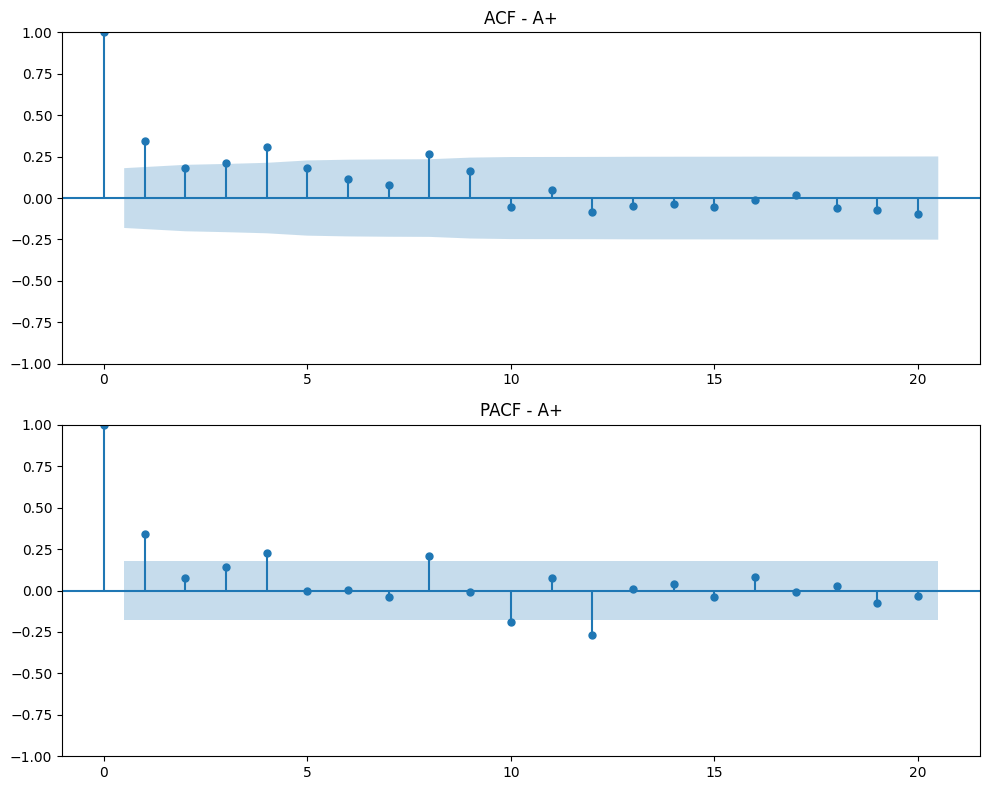

{'ADF Statistic': -0.8786730081699513,
 'p-value': 0.794914551443419,
 'Lags Used': 11,
 'Observations': 106,
 'Critical Values': {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717}}

In [140]:
serie = weekly_demand['A+']
adf_result = adfuller(serie)

# Graficar ACF y PACF
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(serie, lags=20, ax=axes[0])
axes[0].set_title("ACF - A+")

plot_pacf(serie, lags=20, ax=axes[1], method='ywm')
axes[1].set_title("PACF - A+")

plt.tight_layout()
plt.show()

# Resultado ADF
adf_output = {
    "ADF Statistic": adf_result[0],
    "p-value": adf_result[1],
    "Lags Used": adf_result[2],
    "Observations": adf_result[3],
    "Critical Values": adf_result[4]
}

adf_output

In [142]:
# ------------------------- MODELO LSTM -------------------------

    
def entrenar_lstm(X_lstm, y_lstm, epochs=800):
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_lstm.shape[1], 1)),
        BatchNormalization(),
        Dropout(0.2),
        
        LSTM(64, activation='tanh', return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),

        LSTM(32, activation='tanh'),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        Dense(1)  # Última capa sin activación porque es una regresión
        ])
    learning_rate = 0.001 
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=MeanSquaredError()
    )
    
    
    history = model.fit(
        X_lstm, y_lstm,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
  
    return model, history


# ------------------------- STACKING REGRESSOR -------------------------

def entrenar_stacking(X_train, y_train):
    
    estimators = [
        ('xgb', XGBRegressor(max_depth=3, n_estimators=400, learning_rate=0.09, random_state=42, verbosity=0)),
        ('lgb', LGBMRegressor(max_depth=3, n_estimators=400, learning_rate=0.09, random_state=42, verbose=-1)),
        ('cat', CatBoostRegressor(depth=3, iterations=300, learning_rate=0.06, random_state=42, verbose=False))
    ]
    modelo_ensamble = StackingRegressor(
            estimators=estimators,
            final_estimator=Ridge(alpha=1.0),
            n_jobs=-1
        )
    modelo_ensamble.fit(X_train, y_train.ravel())
    return modelo_ensamble

In [144]:
weekly_demand['Lag_A+_1'] = serie.shift(1)
weekly_demand['Lag_A+_2'] = serie.shift(2)
weekly_demand['Lag_A+_3'] = serie.shift(3)
weekly_demand['Lag_A+_4'] = serie.shift(4)
weekly_demand['Rolling_Mean_4_A+'] = serie.rolling(window=4).mean()
weekly_demand['Rolling_Mean_8_A+'] = serie.rolling(window=8).mean()
weekly_demand['Rolling_STD_4_A+'] = serie.rolling(window=4).std()
weekly_demand['Diff_1_A+'] = serie.diff(1)

weekly_demand.rename(columns={'Date':'A+'},inplace=True)
df = weekly_demand.copy()
df['Lag_A+_1'] = df['A+'].shift(1)
df['Lag_A+_2'] = df['A+'].shift(2)
df['Lag_A+_3'] = df['A+'].shift(3)
df['Lag_A+_4'] = df['A+'].shift(4)
df['Rolling_Mean_4_A+'] = df['A+'].rolling(window=4).mean()
df = df.reset_index()
df.rename(columns={'D.O.A': 'Date'}, inplace=True)
#df_a_plus['Date'] = pd.to_datetime(df_a_plus['D.O.A'], errors='coerce')

df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df.dropna(inplace=True)

In [40]:
################# Datos para LSTM A+ ################# 

features = ['Lag_A+_1', 'Lag_A+_2', 'Lag_A+_3', 'Lag_A+_4', 'Rolling_Mean_4_A+']
target = 'A+'
X = df[features]
y = df[[target]]

# Escalado robusto
from sklearn.preprocessing import RobustScaler
scaler_x = RobustScaler()
scaler_y = RobustScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Separo entrenamiento y test (sin barajar porque es una serie temporal)
split_index = int(len(X_scaled) * 0.8)
X_train = X_scaled[:split_index]
X_test = X_scaled[split_index:]
y_lstm = y_scaled[:split_index]
y_test = y_scaled[split_index:]

# Reformatear para LSTM
X_lstm = X_train.reshape((X_train.shape[0], len(features), 1))
X_test_lstm = X_test.reshape((X_test.shape[0], len(features), 1))


In [68]:
# LSTM

modelo_lstm, history = entrenar_lstm(X_lstm, y_lstm)
y_pred_lstm = modelo_lstm.predict(X_test_lstm)

# Desescalar
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)
y_real_lstm = scaler_y.inverse_transform(y_test)


Epoch 1/800


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - loss: 0.4286 - val_loss: 0.8019
Epoch 2/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.4787 - val_loss: 0.8043
Epoch 3/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4549 - val_loss: 0.8087
Epoch 4/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4162 - val_loss: 0.8157
Epoch 5/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4449 - val_loss: 0.8216
Epoch 6/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4214 - val_loss: 0.8275
Epoch 7/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4621 - val_loss: 0.8320
Epoch 8/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4679 - val_loss: 0.8331
Epoch 9/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4647 - val_loss: 0.8322
Epoch 10/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4595 - val_loss: 0.8294
Epoch 11/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4113 - val_loss: 0.8278
Epoch 12/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4492 - val_loss: 0.8274


In [146]:
################# Datos para stackingregressor #################


# Características temporales enriquecidas

df['Rolling_Mean_8_A+'] = df['A+'].rolling(8).mean()
df['Rolling_STD_4_A+'] = df['A+'].rolling(4).std()
df['Diff_1_A+'] = df['A+'].diff(1)


# Eliminar nulos generados por los lags/rolling
df.dropna(inplace=True)
# Definir features y target para stackingregressor
features_stk = [col for col in df.columns if col.startswith('Lag_A+') or 'Rolling_Mean_8_A+' in col or 'Rolling_STD_4_A+' in col or 'Diff_1_A+' in col or col in ['Week', 'Month','Quarter']]

X_stk = df[features_stk]
y = df[target]

scaler_x = RobustScaler()
scaler_y = RobustScaler()

X_scaled = scaler_x.fit_transform(X_stk)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
X_scaled = pd.DataFrame(X_scaled, columns=X_stk.columns)
X_train_stk, X_test_stk, y_train_stk, y_test_stk = train_test_split(X_scaled, y_scaled, shuffle=False, test_size=0.2)


In [148]:
# StackingRegressor

modelo_stk = entrenar_stacking(X_train_stk, y_train_stk)
y_pred_stk = modelo_stk.predict(X_test_stk)
y_pred_stk = scaler_y.inverse_transform(y_pred_stk.reshape(-1, 1))
y_real_stk = scaler_y.inverse_transform(y_test_stk.reshape(-1, 1))

In [150]:
# ------------------------- MÉTRICAS PARA A+ -------------------------

print("* MÉTRICAS LSTM PARA A+")
print(f"MAE: {mean_absolute_error(y_real_lstm, y_pred_lstm):.2f}")
print(f"RMSE: {mean_squared_error(y_real_lstm, y_pred_lstm):.2f}")
print(f"R²: {r2_score(y_real_lstm, y_pred_lstm):.2f}")

print("\n* MÉTRICAS STACKING PARA A+")
print(f"MAE: {mean_absolute_error(y_real_stk, y_pred_stk):.2f}")
print(f"RMSE: {mean_squared_error(y_real_stk, y_pred_stk):.2f}")
print(f"R²: {r2_score(y_real_stk, y_pred_stk):.2f}")


* MÉTRICAS LSTM PARA A+
MAE: 5.99
RMSE: 49.85
R²: 0.68

* MÉTRICAS STACKING PARA A+
MAE: 5.36
RMSE: 48.52
R²: 0.55


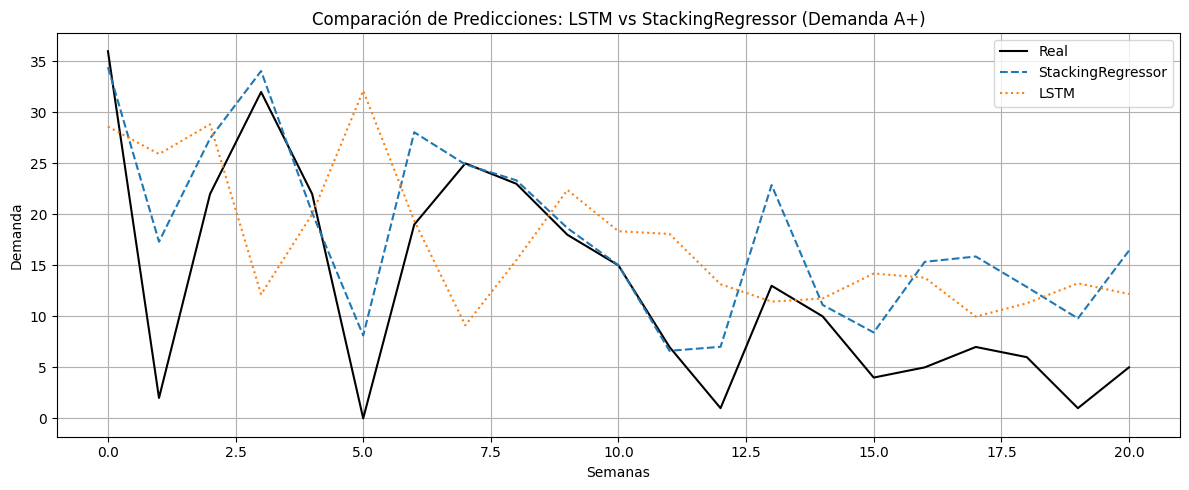

In [152]:
min_len = min(len(y_real_lstm), len(y_pred_lstm), len(y_real_stk), len(y_pred_stk))

# Convertir todo a 1D por seguridad
y_test_plot = y_test[:min_len].reshape(-1)
y_pred_stk_plot = y_pred_stk[:min_len].reshape(-1)
y_pred_lstm_plot = y_pred_lstm[:min_len].reshape(-1)
y_real_plot = y_real_lstm[:min_len].reshape(-1)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(np.arange(min_len), y_real_stk[:min_len], label="Real", color='black')
plt.plot(np.arange(min_len), y_pred_stk[:min_len], label="StackingRegressor", linestyle='--')
plt.plot(np.arange(min_len), y_pred_lstm[:min_len], label="LSTM", linestyle=':')
plt.title("Comparación de Predicciones: LSTM vs StackingRegressor (Demanda A+)")
plt.xlabel("Semanas")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

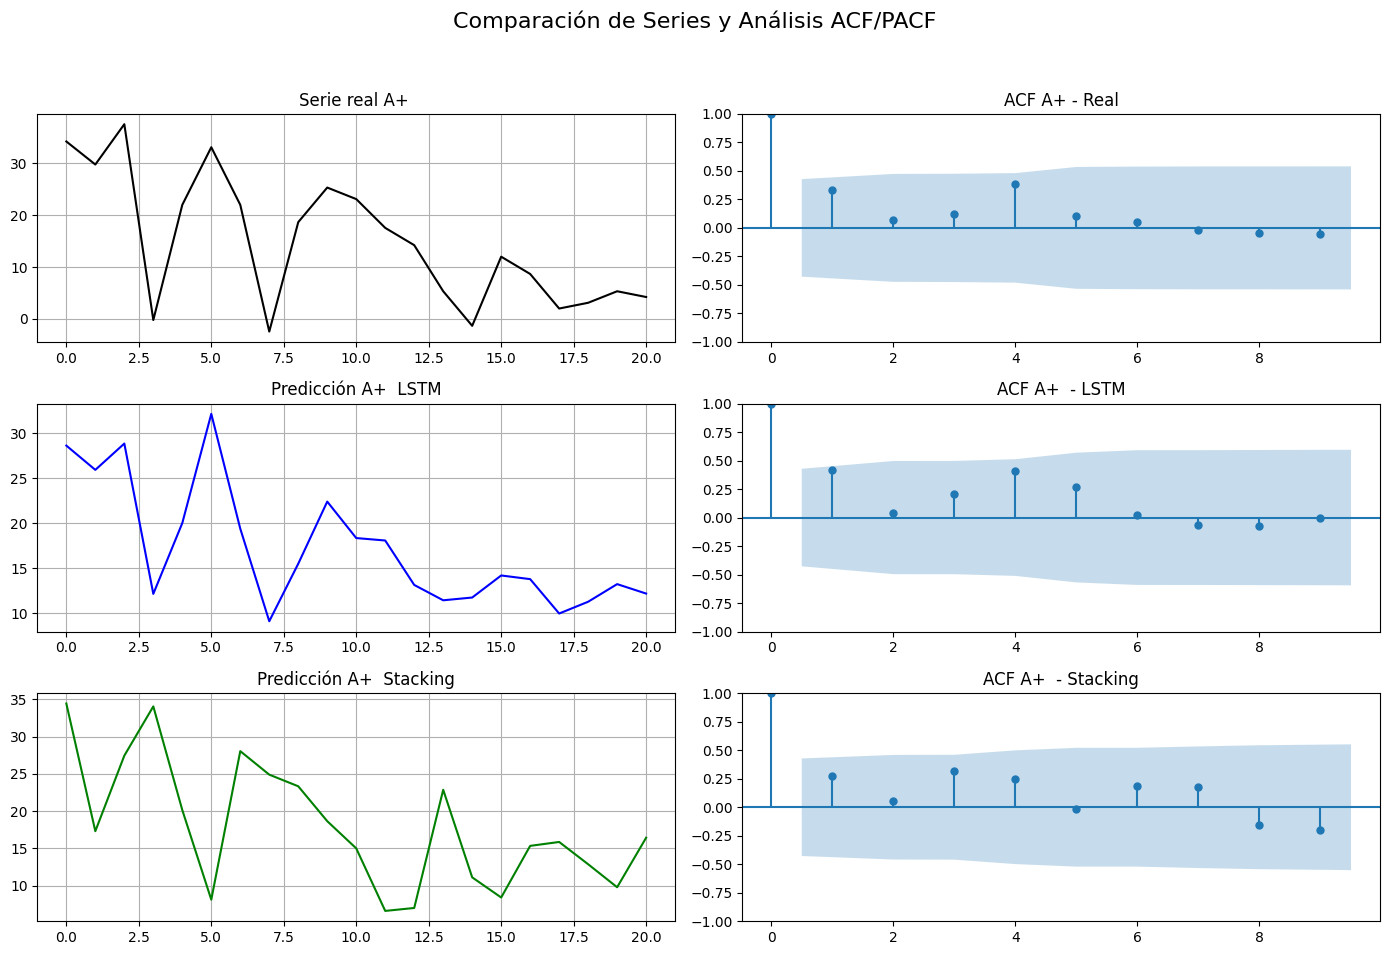

In [154]:
min_len = min(len(y_real_lstm), len(y_pred_lstm), len(y_pred_stk))
y_real_plot = y_real_lstm[:min_len].reshape(-1)
y_pred_lstm_plot = y_pred_lstm[:min_len].reshape(-1)
y_pred_stk_plot = y_pred_stk[:min_len].reshape(-1)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
fig.suptitle("Comparación de Series y Análisis ACF/PACF", fontsize=16)

# Serie real
axes[0, 0].plot(y_real_plot, color='black')
axes[0, 0].set_title("Serie real A+ ")
axes[0, 0].grid(True)

# ACF real
plot_acf(y_real_plot, lags=min(20, len(y_real_plot)//2 - 1), ax=axes[0, 1])
axes[0, 1].set_title("ACF A+ - Real")

# LSTM predicción
axes[1, 0].plot(y_pred_lstm_plot, color='blue')
axes[1, 0].set_title("Predicción A+  LSTM")
axes[1, 0].grid(True)

# ACF LSTM
plot_acf(y_pred_lstm_plot, lags=min(20, len(y_pred_lstm_plot)//2 - 1), ax=axes[1, 1])
axes[1, 1].set_title("ACF A+  - LSTM")

# Stacking predicción
axes[2, 0].plot(y_pred_stk_plot, color='green')
axes[2, 0].set_title("Predicción A+  Stacking")
axes[2, 0].grid(True)

# ACF Stacking
plot_acf(y_pred_stk_plot, lags=min(20, len(y_pred_stk_plot)//2 - 1), ax=axes[2, 1])
axes[2, 1].set_title("ACF A+  - Stacking")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("comparativa_modelos_acf.png", dpi=300)
plt.show()
